# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [1]:
!pip install yfinance
!pip install arch
!pip install pandas_ta
!pip install matplotlib
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=89897a6bf5f385fd6d62b6829a4a0fa46c8111ad212e60f28c58cd47709753c4
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [2]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np
import yfinance as yf


# Define stock ticker and period
ticker = "TSLA"
period = "9y"

# Fetch daily data
daily_df = yf.download(ticker, period=period, interval="1d")

# Fetch intraday 5-min data (Yahoo Finance limits intraday data to ~60 days)
intraday_5min_df = yf.download(ticker, period="60d", interval="5m")

# Display data
print("Daily Data:\n", daily_df.head())
print("Intraday 5-Min Data:\n", intraday_5min_df.head())




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Daily Data:
 Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2016-03-15  14.556000  14.598000  14.100000  14.284667  47707500
2016-03-16  14.795333  14.838667  14.468000  14.533333  52750500
2016-03-17  15.092000  15.233333  14.666667  14.764667  56743500
2016-03-18  15.516000  15.632000  15.204000  15.273333  70677000
2016-03-21  15.888000  15.992000  15.666667  15.689333  79617000
Intraday 5-Min Data:
 Price                           Close        High         Low        Open  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Datetime                                                                    
2024-12-16 14:30:00+00:00  441.890015  443.730011  438.200012  441.132507   
2024-12-16 14:35:00+00:00  446.600006  446.698792  441.750000  441.850006   
2024-12-16 14:40:00+00:00  443.160004  447.410004  442.60000

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

* Finding the best p, q parameters using AIC.
* Fiting the GARCH model with the optimal p, q.
* Generating predictions for volatility.

In [5]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np
import yfinance as yf
from itertools import product

# Define stock ticker and period
ticker = "TSLA"
period = "9y"

# Fetch daily data
daily_df = yf.download(ticker, period=period, interval="1d")

# Compute log returns
daily_df['log_ret'] = np.log(daily_df['Close']).diff()

# Compute rolling variance
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df.dropna()

# Function to find the best p, q parameters
def find_best_garch_params(log_returns, max_p=3, max_q=3):
    best_aic = np.inf
    best_p, best_q = None, None

    for p, q in product(range(1, max_p + 1), range(1, max_q + 1)):
        try:
            model = arch_model(y=log_returns, p=p, q=q)
            result = model.fit(disp='off')

            if result.aic < best_aic:
                best_aic = result.aic
                best_p, best_q = p, q
        except:
            continue

    print(f"Best p, q found: p={best_p}, q={best_q} with AIC={best_aic}")
    return best_p, best_q

# Find the best parameters
best_p, best_q = find_best_garch_params(daily_df['log_ret'].dropna())

# Function to predict volatility
def predict_volatility(x, p, q):
    model = arch_model(y=x, p=p, q=q)
    best_model = model.fit(disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return variance_forecast

# Apply rolling prediction
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x, best_p, best_q))

daily_df = daily_df.dropna()

print(daily_df.head())



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001462. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001462. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/py

Best p, q found: p=1, q=2 with AIC=-7909.469726024131


Streaming output truncated to the last 5000 lines.
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001713. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00175. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by eith

Price           Close       High        Low       Open    Volume   log_ret  \
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA             
Date                                                                         
2017-08-16  24.194000  24.433332  24.167999  24.200001  51207000  0.001600   
2017-08-17  23.461332  24.219999  23.439333  24.080667  75415500 -0.030751   
2017-08-18  23.164000  23.600000  23.053333  23.527332  81123000 -0.012754   
2017-08-21  22.524000  23.054667  22.123333  23.054667  97431000 -0.028018   
2017-08-22  22.756666  22.816000  22.491333  22.742001  64830000  0.010277   

Price       variance predictions  
Ticker                            
Date                              
2017-08-16  0.000514    0.000474  
2017-08-17  0.000513    0.000537  
2017-08-18  0.000514    0.000531  
2017-08-21  0.000509    0.000533  
2017-08-22  0.000509    0.000525  


## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [6]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
daily_df['signal_daily'] = np.where(daily_df['prediction_premium'] > daily_df['premium_std'], 1,
                                   np.where(daily_df['prediction_premium'] < daily_df['premium_std'] * -1, -1, np.nan))

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

Price,Close,High,Low,Open,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,,
2017-08-16,24.194000,24.433332,24.167999,24.200001,51207000,0.001600,0.000514,0.000474,-0.078439,NaN,NaN
2017-08-17,23.461332,24.219999,23.439333,24.080667,75415500,-0.030751,0.000513,0.000537,0.047292,NaN,NaN
2017-08-18,23.164000,23.600000,23.053333,23.527332,81123000,-0.012754,0.000514,0.000531,0.033704,NaN,NaN
2017-08-21,22.524000,23.054667,22.123333,23.054667,97431000,-0.028018,0.000509,0.000533,0.048384,NaN,NaN
2017-08-22,22.756666,22.816000,22.491333,22.742001,64830000,0.010277,0.000509,0.000525,0.030905,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,222.149994,253.369995,220.000000,252.539993,189076900,-0.167546,0.001941,0.002277,0.173541,0.199346,NaN
2025-03-11,230.580002,237.059998,217.020004,225.309998,174896400,0.037245,0.001946,0.001954,0.004372,0.199261,NaN


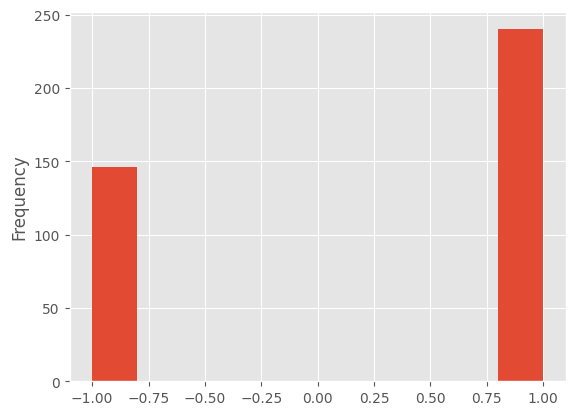

In [7]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [19]:
import pandas_ta

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date) # Convert to datetime


final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('Datetime')


final_df

<ipython-input-19-17b13a584282>:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(['date','Date'], axis=1)\


Price,Close,High,Low,Open,Volume,signal_daily
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Datetime,,,,,,
2024-12-16 14:30:00+00:00,441.890015,443.730011,438.200012,441.132507,8979455,NaN
2024-12-16 14:35:00+00:00,446.600006,446.698792,441.750000,441.850006,3476699,NaN
2024-12-16 14:40:00+00:00,443.160004,447.410004,442.600006,446.540100,2878646,NaN
2024-12-16 14:45:00+00:00,440.660004,444.000000,440.150085,443.250000,2393163,NaN
2024-12-16 14:50:00+00:00,438.070312,440.819885,437.149994,440.547913,2656657,NaN
...,...,...,...,...,...,...
2025-03-14 19:35:00+00:00,248.460007,248.880005,248.009995,248.589996,832860,NaN
2025-03-14 19:40:00+00:00,248.199997,248.570007,247.789993,248.449997,970857,NaN


In [20]:

final_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in final_df.columns]


final_df = final_df.drop(columns=[col for col in final_df.columns if 'Ticker' in col])


final_df = final_df.reset_index().set_index('Datetime')



In [22]:
# Renaming the colums
ticker = ticker.upper()


final_df.columns = [
    col.replace(f"_{ticker}", "").rstrip("_").lower() for col in final_df.columns
]

# Display the updated column names
print(final_df.head())


                                close        high         low        open  \
Datetime                                                                    
2024-12-16 14:30:00+00:00  441.890015  443.730011  438.200012  441.132507   
2024-12-16 14:35:00+00:00  446.600006  446.698792  441.750000  441.850006   
2024-12-16 14:40:00+00:00  443.160004  447.410004  442.600006  446.540100   
2024-12-16 14:45:00+00:00  440.660004  444.000000  440.150085  443.250000   
2024-12-16 14:50:00+00:00  438.070312  440.819885  437.149994  440.547913   

                            volume  signal_daily  
Datetime                                          
2024-12-16 14:30:00+00:00  8979455           NaN  
2024-12-16 14:35:00+00:00  3476699           NaN  
2024-12-16 14:40:00+00:00  2878646           NaN  
2024-12-16 14:45:00+00:00  2393163           NaN  
2024-12-16 14:50:00+00:00  2656657           NaN  


In [23]:
final_df

,close,high,low,open,volume,signal_daily
Datetime,,,,,,
2024-12-16 14:30:00+00:00,441.890015,443.730011,438.200012,441.132507,8979455,NaN
2024-12-16 14:35:00+00:00,446.600006,446.698792,441.750000,441.850006,3476699,NaN
2024-12-16 14:40:00+00:00,443.160004,447.410004,442.600006,446.540100,2878646,NaN
2024-12-16 14:45:00+00:00,440.660004,444.000000,440.150085,443.250000,2393163,NaN
2024-12-16 14:50:00+00:00,438.070312,440.819885,437.149994,440.547913,2656657,NaN
...,...,...,...,...,...,...
2025-03-14 19:35:00+00:00,248.460007,248.880005,248.009995,248.589996,832860,NaN
2025-03-14 19:40:00+00:00,248.199997,248.570007,247.789993,248.449997,970857,NaN
2025-03-14 19:45:00+00:00,248.729996,248.820007,247.839996,248.179993,1109121,NaN


In [24]:
final_df['close']

,close
Datetime,
2024-12-16 14:30:00+00:00,441.890015
2024-12-16 14:35:00+00:00,446.600006
2024-12-16 14:40:00+00:00,443.160004
2024-12-16 14:45:00+00:00,440.660004
2024-12-16 14:50:00+00:00,438.070312
...,...
2025-03-14 19:35:00+00:00,248.460007
2025-03-14 19:40:00+00:00,248.199997
2025-03-14 19:45:00+00:00,248.729996


In [25]:


final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)


final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi'] > 70) &
                                                            (x['close'] > x['uband'])
                                             else (-1 if (x['rsi'] < 30) &
                                                         (x['close'] < x['lband']) else np.nan),
                                             axis=1)


final_df['return'] = np.log(final_df['close']).diff()

final_df

,close,high,low,open,volume,signal_daily,rsi,lband,uband,signal_intraday,return
Datetime,,,,,,,,,,,
2024-12-16 14:30:00+00:00,441.890015,443.730011,438.200012,441.132507,8979455,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-16 14:35:00+00:00,446.600006,446.698792,441.750000,441.850006,3476699,NaN,NaN,NaN,NaN,NaN,0.010602
2024-12-16 14:40:00+00:00,443.160004,447.410004,442.600006,446.540100,2878646,NaN,NaN,NaN,NaN,NaN,-0.007732
2024-12-16 14:45:00+00:00,440.660004,444.000000,440.150085,443.250000,2393163,NaN,NaN,NaN,NaN,NaN,-0.005657
2024-12-16 14:50:00+00:00,438.070312,440.819885,437.149994,440.547913,2656657,NaN,NaN,NaN,NaN,NaN,-0.005894
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 19:35:00+00:00,248.460007,248.880005,248.009995,248.589996,832860,NaN,48.146458,247.928179,251.444961,NaN,-0.000624
2025-03-14 19:40:00+00:00,248.199997,248.570007,247.789993,248.449997,970857,NaN,46.854147,247.742323,251.490826,NaN,-0.001047
2025-03-14 19:45:00+00:00,248.729996,248.820007,247.839996,248.179993,1109121,NaN,49.748259,247.661059,251.488600,NaN,0.002133


In [26]:
final_df['signal_intraday'].count()

128

## 5. Generate the position entry and hold until the end of the day.

In [27]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

In [28]:
final_df

,close,high,low,open,volume,signal_daily,rsi,lband,uband,signal_intraday,return,return_sign,forward_return,strategy_return
Datetime,,,,,,,,,,,,,,
2024-12-16 14:30:00+00:00,441.890015,443.730011,438.200012,441.132507,8979455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010602,NaN
2024-12-16 14:35:00+00:00,446.600006,446.698792,441.750000,441.850006,3476699,NaN,NaN,NaN,NaN,NaN,0.010602,NaN,-0.007732,NaN
2024-12-16 14:40:00+00:00,443.160004,447.410004,442.600006,446.540100,2878646,NaN,NaN,NaN,NaN,NaN,-0.007732,NaN,-0.005657,NaN
2024-12-16 14:45:00+00:00,440.660004,444.000000,440.150085,443.250000,2393163,NaN,NaN,NaN,NaN,NaN,-0.005657,NaN,-0.005894,NaN
2024-12-16 14:50:00+00:00,438.070312,440.819885,437.149994,440.547913,2656657,NaN,NaN,NaN,NaN,NaN,-0.005894,NaN,-0.000252,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 19:35:00+00:00,248.460007,248.880005,248.009995,248.589996,832860,NaN,48.146458,247.928179,251.444961,NaN,-0.000624,NaN,-0.001047,NaN
2025-03-14 19:40:00+00:00,248.199997,248.570007,247.789993,248.449997,970857,NaN,46.854147,247.742323,251.490826,NaN,-0.001047,NaN,0.002133,NaN
2025-03-14 19:45:00+00:00,248.729996,248.820007,247.839996,248.179993,1109121,NaN,49.748259,247.661059,251.488600,NaN,0.002133,NaN,0.004993,NaN


## 6. Calculate final strategy returns.

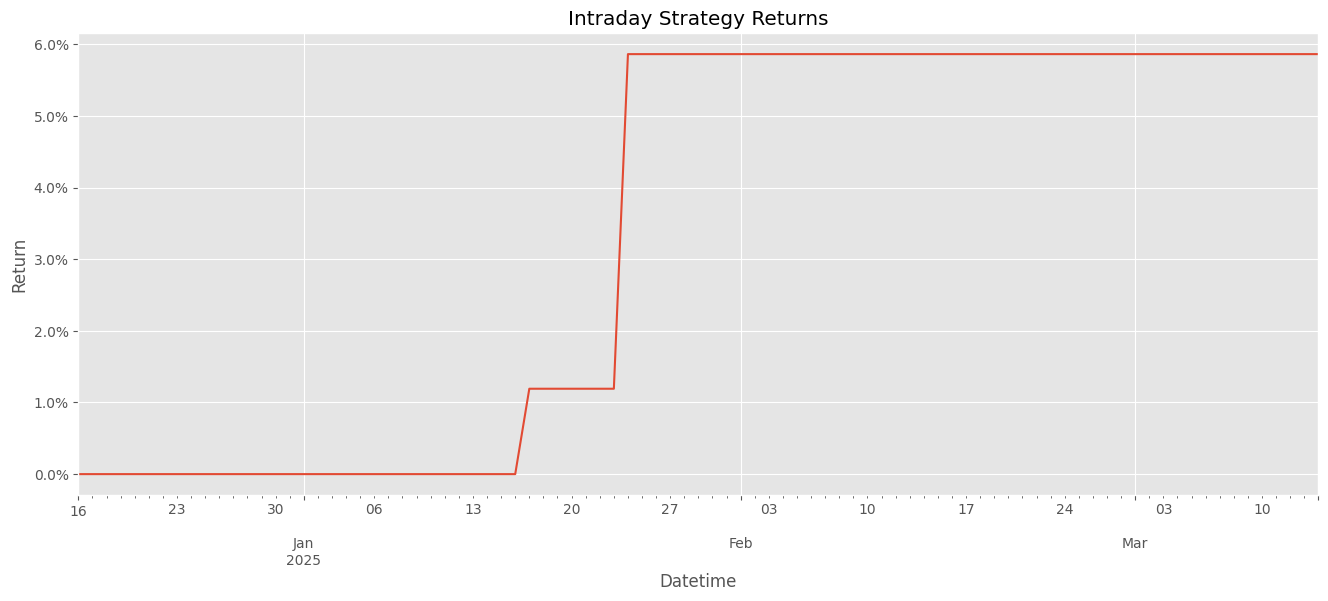

In [29]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
